<img src="https://miro.medium.com/max/1898/1*w4TIZ1VIu7J2FltbyZ6bYA.png" align='left' />

# Desafio 2 - [Competição Titanic](https://www.kaggle.com/c/titanic/overview)

Nesse desafio vamos trabalhar com uma competição do Kaggle pela primeira vez. O objetivo da competição é criar um modelo que consiga prever quais passageiros morreram e quais sobreviveram no acidente do Titanic.

A comunidade do Kaggle disponibiliza os notebooks com possíveis soluções para a competição. É uma fonte super rica de aprendizado entender as ideias que outras pessoas tiveram e ver as aplicações dessas ideias. Não hesitem em consultar! (Só não vale copiar a solução das pessoas na íntegra hehe)

Abaixo deixamos um passo-a-passo dos macro blocos para nortear vocês! Esse Desafio é uma ótima oportunidade para juntarmos os bloquinhos de Lego e vermos as aplicações de boa parte das técnicas e conceitos vistos até agora! Bora lá!

# 1. Importar libs e carregar os DataFrames

Nas competições do Kaggle é comum recebermos 2 DataFrames. Um de treino e um de teste. Neste caso o DataFrame de **teste** é utilizado apenas para gerar o Score do modelo na competição. Nós realizamos todas as etapas no DataFrame de treino e utilizamos o teste apenas para submeter a solução.

In [423]:
import pandas as pd
import numpy as np

# Data Prep
from feature_engine.categorical_encoders import CountFrequencyCategoricalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from category_encoders import TargetEncoder

# boruta
from boruta import BorutaPy
from pycaret.datasets import get_data
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV, f_classif, chi2

# visualização
import seaborn as sns
import matplotlib.pyplot as plt

# modelo
import statsmodels.formula.api as smf
import statsmodels.api as sm

# métricas
from sklearn.metrics import roc_curve, roc_auc_score,accuracy_score, recall_score, precision_score, auc
from sklearn.metrics import classification_report, f1_score, fbeta_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report

import warnings
warnings.filterwarnings('ignore')

In [424]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_gender = pd.read_csv('gender_submission.csv')

# 2. Dividir o Dataset de Treino em treino e teste

Conforme vimos nas aulas, antes de começar a trabalhar com os dados, nós separamos uma parte do DataFrame para posterior avaliação do modelo. É importante que o modelo não tenha contato com nenhuma informação deste DataFrame separado para garantir que quando avaliada sobre este DataFrame, a performance do modelo reflita o comportamento do mesmo para dados nunca vistos.

In [425]:
# o próprio kaggle já envia dois csv separados, o de testes não possui o campo Survived preenchido
# Mas abaixo após feature engineering / dataprep se refaz o dataset e se divide o de treino

In [426]:
df_train.sample(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
350,351,0,3,"Odahl, Mr. Nils Martin",male,23.0,0,0,7267,9.225,NaN,S
342,343,0,2,"Collander, Mr. Erik Gustaf",male,28.0,0,0,248740,13.000,NaN,S
754,755,1,2,"Herman, Mrs. Samuel (Jane Laver)",female,48.0,1,2,220845,65.000,NaN,S
245,246,0,1,"Minahan, Dr. William Edward",male,44.0,2,0,19928,90.000,C78,Q
526,527,1,2,"Ridsdale, Miss. Lucy",female,50.0,0,0,W./C. 14258,10.500,NaN,S
63,64,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.900,NaN,S


In [427]:
df_test.sample(6)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
360,1252,3,"Sage, Master. William Henry",male,14.5,8,2,CA. 2343,69.5500,NaN,S
27,919,3,"Daher, Mr. Shedid",male,22.5,0,0,2698,7.2250,NaN,C
357,1249,3,"Lockyer, Mr. Edward",male,NaN,0,0,1222,7.8792,NaN,S
267,1159,3,"Warren, Mr. Charles William",male,NaN,0,0,C.A. 49867,7.5500,NaN,S
19,911,3,"Assaf Khalil, Mrs. Mariana (Miriam"")""",female,45.0,0,0,2696,7.2250,NaN,C
381,1273,3,"Foley, Mr. Joseph",male,26.0,0,0,330910,7.8792,NaN,Q


# 3. Limpeza de Dados

Agora, vamos verificar a consistência dos dados. Hora de identificar e tratar valores nulos, remover linhas e/ou colunas duplicadas, identificar e remover inconsistências nos valores das variáveis (Ex. se houver Fare negativo, não faz sentido), identificar e remover colunas constantes, quase constantes e com baixa variância. (Uma boa dica é voltar lá no Módulo 0 e revisitar a aula de Limpeza de Dados).

In [428]:
# Checando a quantidade de linhas e colunas
print(f'O Conjunto de Dados possui de treino: {df_train.shape[0]} linhas e {df_train.shape[1]} colunas')
print(f'O Conjunto de Dados possui de teste: {df_test.shape[0]} linhas e {df_test.shape[1]} colunas')

O Conjunto de Dados possui de treino: 891 linhas e 12 colunas
O Conjunto de Dados possui de teste: 418 linhas e 11 colunas


In [429]:
# checando duplicadas nas linhas
print(f'Temos em treino {df_train.duplicated().sum()} linhas duplicadas')
print(f'Temos em teste {df_test.duplicated().sum()} linhas duplicadas')

Temos em treino 0 linhas duplicadas
Temos em teste 0 linhas duplicadas


In [430]:
# checando duplicadas nas colunas
print(f'Temos em treino {df_train.T.duplicated().sum()} colunas duplicadas')
print(f'Temos em teste {df_test.T.duplicated().sum()} colunas duplicadas')

Temos em treino 0 colunas duplicadas
Temos em teste 0 colunas duplicadas


In [431]:
# treino tem missing values em Age, Cabin, Embarked
print(df_train.info())
df_train.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
377,378,0,1,"Widener, Mr. Harry Elkins",male,27.0,0,2,113503,211.5000,C82,C
593,594,0,3,"Bourke, Miss. Mary",female,NaN,0,2,364848,7.7500,NaN,Q
770,771,0,3,"Lievens, Mr. Rene Aime",male,24.0,0,0,345781,9.5000,NaN,S
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C
698,699,0,1,"Thayer, Mr. John Borland",male,49.0,1,1,17421,110.8833,C68,C
622,623,1,3,"Nakid, Mr. Sahid",male,20.0,1,1,2653,15.7417,NaN,C
734,735,0,2,"Troupiansky, Mr. Moses Aaron",male,23.0,0,0,233639,13.0000,NaN,S
608,609,1,2,"Laroche, Mrs. Joseph (Juliette Marie Louise La...",female,22.0,1,2,SC/Paris 2123,41.5792,NaN,C
871,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S
774,775,1,2,"Hocking, Mrs. Elizabeth (Eliza Needs)",female,54.0,1,3,29105,23.0000,NaN,S


In [432]:
# teste tem missing values em Age, Cabin, Fare
print(df_test.info())
df_test.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
54,946,2,"Mangiavacchi, Mr. Serafino Emilio",male,NaN,0,0,SC/A.3 2861,15.5792,NaN,C
304,1196,3,"McCarthy, Miss. Catherine Katie""""",female,NaN,0,0,383123,7.7500,NaN,Q
363,1255,3,"Strilic, Mr. Ivan",male,27.00,0,0,315083,8.6625,NaN,S
316,1208,1,"Spencer, Mr. William Augustus",male,57.00,1,0,PC 17569,146.5208,B78,C
202,1094,1,"Astor, Col. John Jacob",male,47.00,1,0,PC 17757,227.5250,C62 C64,C
398,1290,3,"Larsson-Rondberg, Mr. Edvard A",male,22.00,0,0,347065,7.7750,NaN,S
307,1199,3,"Aks, Master. Philip Frank",male,0.83,0,1,392091,9.3500,NaN,S
325,1217,3,"Assam, Mr. Ali",male,23.00,0,0,SOTON/O.Q. 3101309,7.0500,NaN,S
206,1098,3,"McGowan, Miss. Katherine",female,35.00,0,0,9232,7.7500,NaN,Q
121,1013,3,"Kiernan, Mr. John",male,NaN,1,0,367227,7.7500,NaN,Q


In [433]:
# checando missing values
print(f'Missing values treino:\n{df_train.isna().sum()}') # age, cabin, embarked
print(f'\nMissing values teste:\n{df_test.isna().sum()}') # age, cabin, fare

Missing values treino:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Missing values teste:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [434]:
# lista dos dfs
dfs = [df_train, df_test]

# Junção dos 2 datasets
df_all = pd.concat(dfs, sort=True).reset_index(drop=True)

In [435]:
df_all.sample(10)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
934,30.0,NaN,S,13.0000,"Corbett, Mrs. Walter H (Irene Colvin)",0,935,2,female,0,NaN,237249
1171,23.0,NaN,S,8.6625,"Oreskovic, Miss. Jelka",0,1172,3,female,0,NaN,315085
1013,35.0,C28,C,57.7500,"Schabert, Mrs. Paul (Emma Mock)",0,1014,1,female,1,NaN,13236
1110,NaN,NaN,S,8.0500,"Thomson, Mr. Alexander Morrison",0,1111,3,male,0,NaN,32302
1191,32.0,NaN,S,7.7750,"Olsson, Mr. Oscar Wilhelm",0,1192,3,male,0,NaN,347079
1018,NaN,NaN,Q,23.2500,"McCoy, Miss. Alicia",0,1019,3,female,2,NaN,367226
636,32.0,NaN,S,7.9250,"Leinonen, Mr. Antti Gustaf",0,637,3,male,0,0.0,STON/O 2. 3101292
673,31.0,NaN,S,13.0000,"Wilhelms, Mr. Charles",0,674,2,male,0,1.0,244270
1183,NaN,NaN,C,7.2292,"Nasr, Mr. Mustafa",0,1184,3,male,0,NaN,2652
1211,26.0,NaN,S,7.7750,"Andersson, Mr. Johan Samuel",0,1212,3,male,0,NaN,347075


In [436]:
# checando se não há Fare negativo
print(df_train.loc[df_train['Fare']<0].count()[['PassengerId']])
print(df_test.loc[df_test['Fare']<0].count()[['PassengerId']])
print(df_all.loc[df_all['Fare']<0].count()[['PassengerId']])

PassengerId    0
dtype: int64
PassengerId    0
dtype: int64
PassengerId    0
dtype: int64


In [437]:
# verificar se há algum valor <= 0
qtd = 0
cols = ['Age', 'Fare', 'Parch', 'PassengerId', 'Pclass','SibSp', 'Survived']
for col in cols:
    if (df_train[col] < 0).any():
        print(df_train[col])
    else:
        print("Todos valores >= 0 da coluna {}".format(col))

Todos valores >= 0 da coluna Age
Todos valores >= 0 da coluna Fare
Todos valores >= 0 da coluna Parch
Todos valores >= 0 da coluna PassengerId
Todos valores >= 0 da coluna Pclass
Todos valores >= 0 da coluna SibSp
Todos valores >= 0 da coluna Survived


In [438]:
# checando baixa variância das variáveis int e float
minmax = MinMaxScaler()

# variáveis teste df_train
variaveis_numericas_train = df_train.select_dtypes(include=['int', 'float'])
variaveis_num_escaladas_train = minmax.fit_transform(variaveis_numericas_train)
variaveis_num_escaladas_train = pd.DataFrame(variaveis_num_escaladas_train, columns=variaveis_numericas_train.columns)

# variáveis teste df_test
variaveis_numericas_test = df_train.select_dtypes(include=['int', 'float'])
variaveis_num_escaladas_test = minmax.fit_transform(variaveis_numericas_test)
variaveis_num_escaladas_test = pd.DataFrame(variaveis_num_escaladas_test, columns=variaveis_numericas_test.columns)

In [439]:
# variância train
listLowVariance_train = []
for col in variaveis_num_escaladas_train.columns:
    if np.var(variaveis_num_escaladas_train[col]) > 0.001:
        print(f'{col} possui variância considerável')
    else:
        print(f'{col} possui baixa variância')
        listLowVariance.append(col)

Age possui variância considerável
Fare possui variância considerável


In [440]:
# variância test
listLowVariance_test = []
for col in variaveis_num_escaladas_test.columns:
    if np.var(variaveis_num_escaladas_test[col]) > 0.001:
        print(f'{col} possui variância considerável')
    else:
        print(f'{col} possui baixa variância')
        listLowVariance.append(col)

Age possui variância considerável
Fare possui variância considerável


# 4. Análise Exploratória de Dados (EDA)

Hora de conhecer os dados! Entender qual é a variável target, o que cada uma das colunas representa, quais as variáveis qualitativas, quais as variáveis quantitativas, observar as distribuições das variáveis e observar relações das variáveis com o target e entre si. Super válido procurar mais informações sobre o Titanic também (maior entendimento do negócio). Como funcionava a venda de passagens? Como as cabines eram distribuídas no navio?

Qual é o tipo de problema que vamos tentar resolver? É um problema de aprendizado supervisionado ou não supervisionado? Regressão ou Classificação?

PassengerId: id único de identificação do passageiro
Survived: flag que indica sobrevivência ou não - é o que se busca prever (target) - classificação binária
   0 = Não Sobreviveu
   1 = Sobreviveu
Pclass (Classe Passageiro): status socioeconômico do passageiro, ordinal categórica com 3 valores (1, 2 ou 3):
   1 = Classe alta
   2 = Classe Média
   3 = Classe Baixa
Name, Sex e Age são autoexplicativos
SibSp: número total de parentes e/ou cônjuges dos passageiros
Parch: número total de pais e filhos dos passageiros
Ticket: número do bilhete do passageiro
Fare: tarifa do passageiro
Cabin: número da cabine do passageiro
Embarked: porto de embarque, variável categórica com 3 valores possíveis (C, Q ou S):
   C = Cherbourg
   Q = Queenstown
   S = Southampton

In [441]:
# Real: 1502 mortos e 722 sobreviventes  

# No dataset treino - 38,4% sobreviventes
print(df_train.groupby('Survived').count()[['PassengerId']])
print(df_train.loc[df_train['Survived']==1].groupby('Survived').count()[['PassengerId']] / df_train['PassengerId'].count())

          PassengerId
Survived             
0                 549
1                 342
          PassengerId
Survived             
1            0.383838


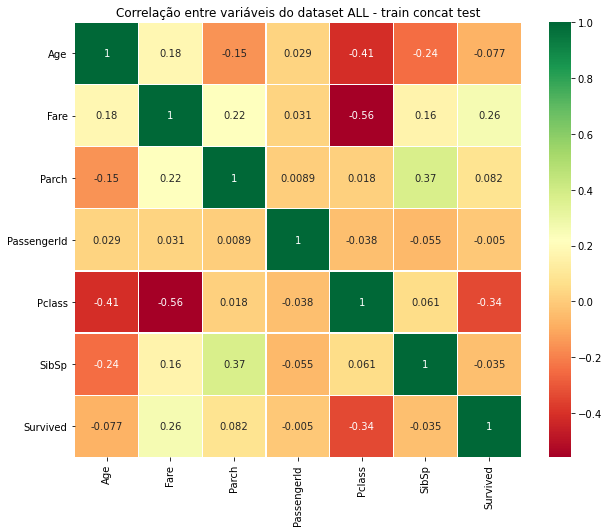

In [442]:
# variáveis não muito correlatas - melhor valor SibSp e Parch
sns.heatmap(df_all.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.title('Correlação entre variáveis do dataset ALL - train concat test')
plt.show()

In [443]:
# dados faltantes treino e teste e seus %

# Treino

print('T R E I N O:\n')

Miss_Train_Value = df_train.isnull().sum().sort_values(ascending=False)
Miss_Train_Perc = df_train.isnull().sum()/df_train.isnull().count()*100

print(Miss_Train_Value.head(3))
print(Miss_Train_Perc.sort_values(ascending=False).head(3))

# Teste

print('\n------')

print('T E S T E:\n')

Miss_Test_Value = df_test.isnull().sum().sort_values(ascending=False)
Miss_Test_Perc = df_test.isnull().sum()/df_test.isnull().count()*100

print(Miss_Test_Value.head(3))
print(Miss_Test_Perc.sort_values(ascending=False).head(3))

T R E I N O:

Cabin       687
Age         177
Embarked      2
dtype: int64
Cabin       77.104377
Age         19.865320
Embarked     0.224467
dtype: float64

------
T E S T E:

Cabin    327
Age       86
Fare       1
dtype: int64
Cabin    78.229665
Age      20.574163
Fare      0.239234
dtype: float64


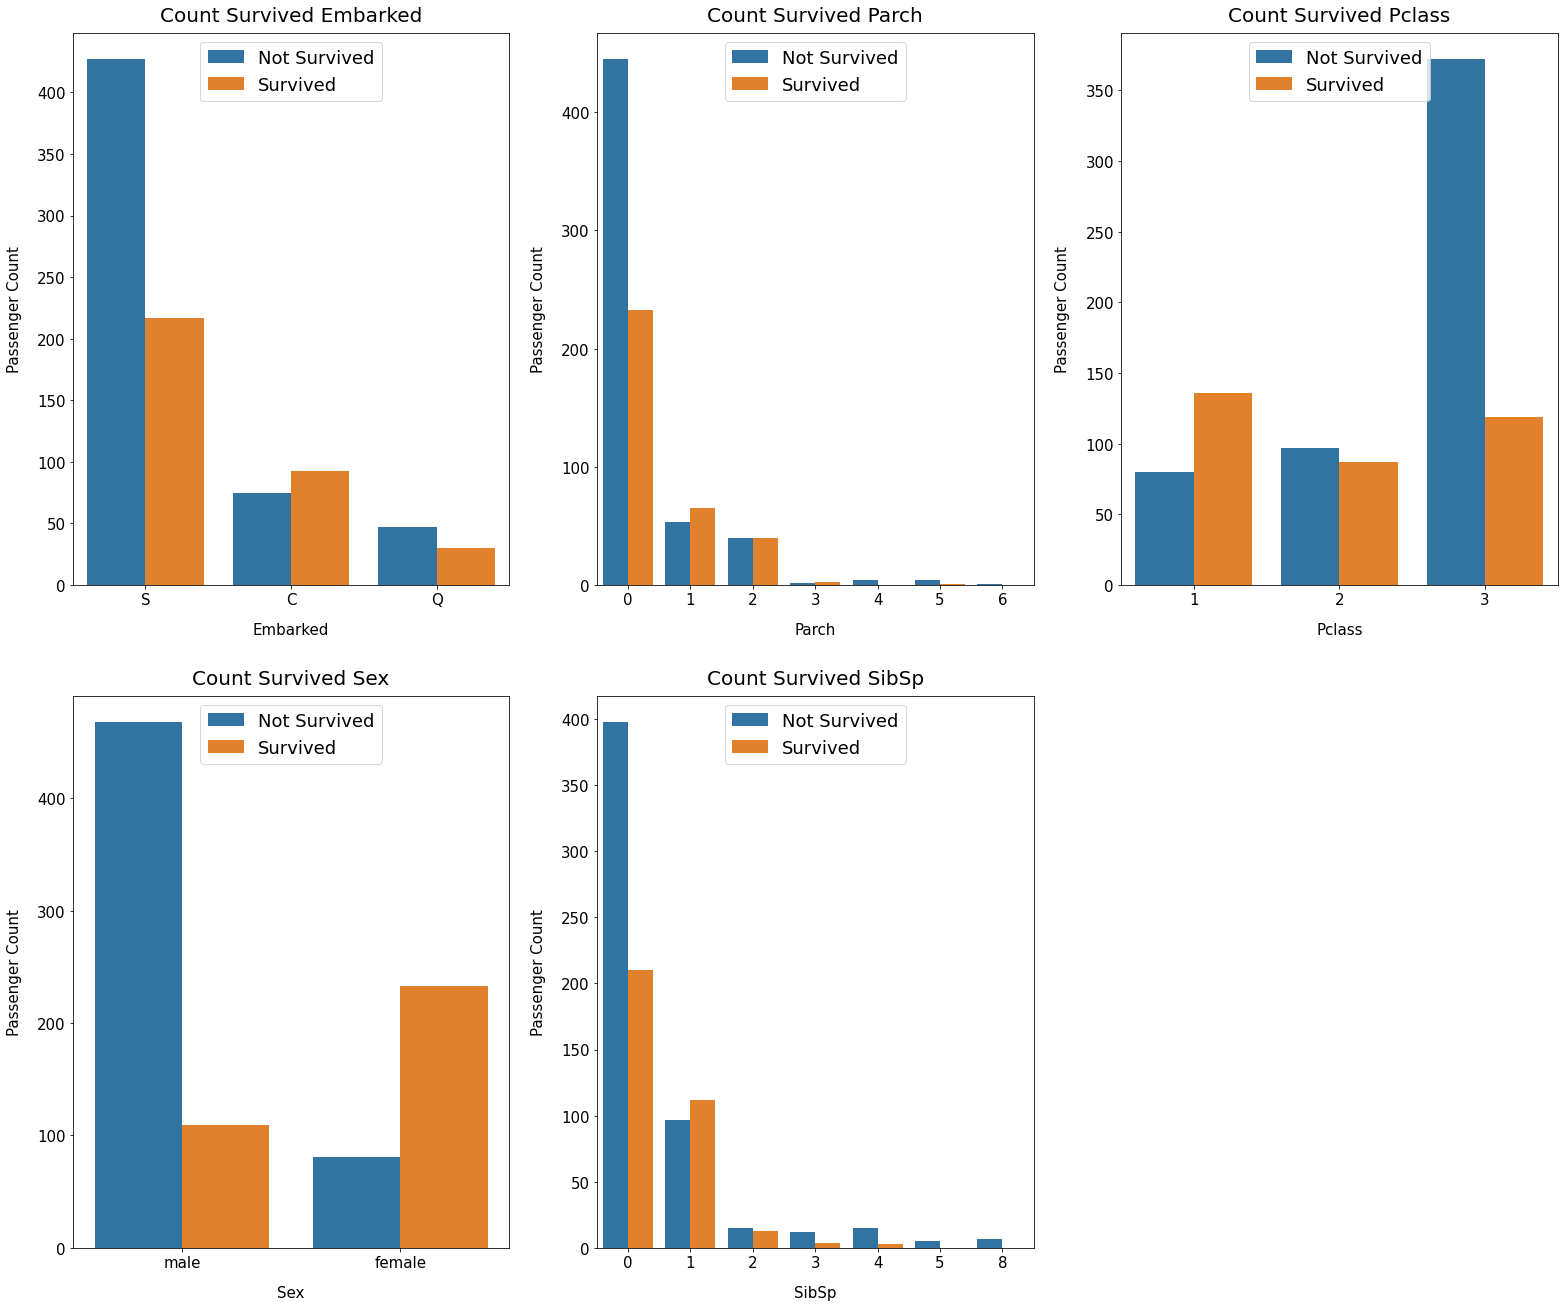

In [444]:
# análise variáveis categóricas

# > tendência à sobrevivência 
  # embarcados em Cherbourg
  # tamanhos de família entre 2 a 4 integrantes
  # classe Alta
  # sexo feminino

# < tendência à sobrevivência 
  # embarcados em Southampton
  # tamanhos de família: viajante solitário ou > 4
  # classe baixa
  # sexo masculino  

category_vars = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 15))
plt.subplots_adjust(right=1.5, top=1.25)

for i, field in enumerate(category_vars, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=field, hue='Survived', data=df_train)
    
    plt.xlabel('{}'.format(field), size=15, labelpad=15)
    plt.ylabel('Passenger Count', size=15, labelpad=15)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count Survived {}'.format(field), size=20, y=1.01)

plt.show()

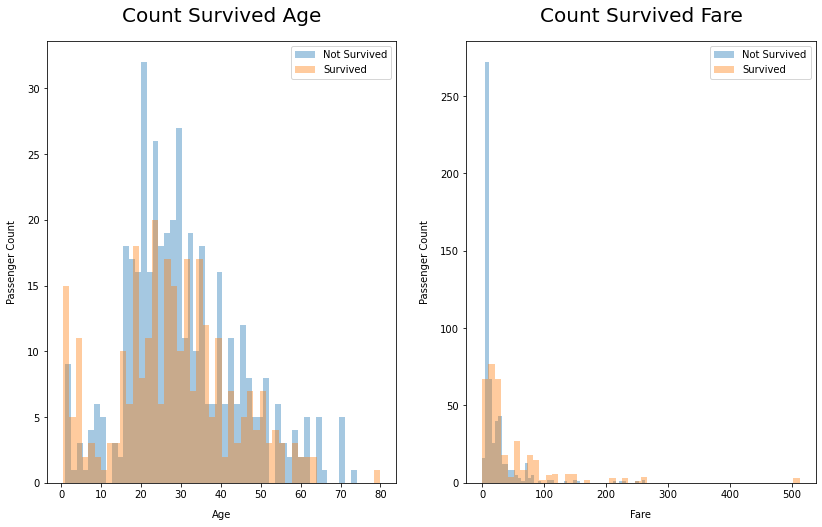

In [445]:
# análise variáveis contínuas

# > tendência à sobrevivência 
  # menores de 15 anos
  # taxas mais caras de entrada

# < tendência à sobrevivência 
  # alta taxa de mortalidade entre 20 e 30 anos 
  # taxas mais baratas de entrada

num_vars = ['Age', 'Fare']

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 12))
plt.subplots_adjust(right=1.5, top=1.25)

for i, field in enumerate(num_vars, 1):    
    plt.subplot(2, 3, i)
    
    df_filter = df_train.loc[df_train['Survived']==0]
    sns.distplot(df_filter[field],bins=50,kde=False,hist=True)

    df_filter = df_train.loc[df_train['Survived']==1]
    sns.distplot(df_filter[field],bins=50,kde=False,hist=True)
    
    plt.xlabel('{}'.format(field), size=10, labelpad=10)
    plt.ylabel('Passenger Count', size=10, labelpad=10)    
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 10})
    plt.title('Count Survived {}'.format(field), size=20, y=1.03)

plt.show()

# 5. Feature Engineering

Agora que temos os dados limpos e entendemos um pouco mais do problema de negócio, hora de tentar criar variáveis, a partir das existentes, para aumentar a explicabilidade do modelo. Vale consultar a aba de **Notebooks** da competição, observar ideias que as pessoas tiveram e aplicar elas aqui. Como falamos em aula, não tem uma receita para feature engineering, a experiência conta bastante então é um bom momento para pegarmos umas ideias diferentes.

Deixo algumas ideias aqui: será que o fato de o número da cabine ser nulo têm alguma influência sobre a probabilidade de a pessoa sobreviver ou não? Na variável com o nome do passageiro, temos o título (Mr., Mrs., etc). Será que o título, de alguma forma, contribui para a probabilidade de sobrevivência?

Usem a criatividade e, principalmente, testem várias coisas diferentes!!

In [446]:
# Excluir Cabin - muitos dados faltantes
df_all.drop(['Cabin'], inplace=True, axis=1)

In [447]:
# Preencher Fare, Age e Embarked - poucos dados 

# Median Fare para condition([3][0][0] - 3=Pclass,0=Parch,SibSp) 
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp'])['Fare'].median()[3][0][0]
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

# Preenchendo missing values Embarked com 'S' - o de > frequencia
df_all['Embarked'] = df_all['Embarked'].fillna('S')

# Preenchendo missing values Age com medians de Sex e Pclass
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

In [448]:
# criar Title e IsMarried
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1 # índice alto de sobrevivência

In [449]:
# criando Family Size = Parch + SibSp
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

# criando Family_Size_Grouped
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

In [450]:
df_all.groupby('Ticket')['Ticket'].transform('count')

0       1
1       2
2       1
3       2
4       1
       ..
1304    1
1305    3
1306    1
1307    1
1308    3
Name: Ticket, Length: 1309, dtype: int64

In [451]:
# Dividindo - separando df_train e df_test
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]

In [452]:
# verificar se tem NULL no df_train 
100*(df_train.isnull().sum()/df_train.shape[0])

Age                    0.0
Embarked               0.0
Fare                   0.0
Name                   0.0
Parch                  0.0
PassengerId            0.0
Pclass                 0.0
Sex                    0.0
SibSp                  0.0
Survived               0.0
Ticket                 0.0
Title                  0.0
Is_Married             0.0
Family_Size            0.0
Family_Size_Grouped    0.0
dtype: float64

# 6. Feature Selection

De todas as Features que temos, vamos identificar quais, de fato, são relevates para o nosso problema. Faremos isso em duas etapas, como vimos em aula.

### 6.1 Filter Method

Nesta etapa verificamos se as relações observadas entre as variáveis e o target são estatisticamente significativas. Para isso, utilizamos testes de hipótese como ANOVA e chi2. Analisando os p-valores, identificamos variáveis que não são estatisticamente significativas e as removemos do conjunto.

### 6.2 Wrapper Method

Aqui utilizamos alguns algoritmos como Boruta ou RFE, cuja ideia é identificar quais as variáveis que, de fato contribuem para o modelo. Tais algoritmos fazem isso, por exemplo, testando a feature contra uma versão randomizada de si mesma ou avaliando se um modelo com a feature performa signficativamente melhor do que o mesmo modelo sem a feature em questão.

In [453]:
df_train.columns

Index(['Age', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId', 'Pclass',
       'Sex', 'SibSp', 'Survived', 'Ticket', 'Title', 'Is_Married',
       'Family_Size', 'Family_Size_Grouped'],
      dtype='object')

In [454]:
# validação ANOVA e CHI2

# divisão e escolha variáveis
X = df_train.drop('Survived',axis=1)
Y = df_train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.7, random_state=123)

# separação variáveis
X_train_num = X_train.loc[:,['Age', 'Fare', 'Parch', 'SibSp', 'Family_Size']] # usa o anova
X_train_cat = X_train.loc[:,['Pclass', 'Is_Married']] # usa o chi2

In [455]:
# ANOVA análise
selected_anova = f_classif(X_train_num, y_train)
selected_anova

(array([ 3.15167006, 38.73040452,  5.68828085,  1.02581759,  0.18378523]),
 array([7.63390121e-02, 8.95328978e-10, 1.73775798e-02, 3.11537476e-01,
        6.68288914e-01]))

In [456]:
p_values_num = pd.Series(selected_anova[1])
p_values_num.index = X_train_num.columns 
p_values_num = p_values_num[p_values_num<0.05]
p_values_num.index

Index(['Fare', 'Parch'], dtype='object')

In [457]:
# chi2 análise
selected_chi2 = chi2(X_train_cat, y_train)
selected_chi2

(array([19.67441998, 55.34951837]), array([9.18223175e-06, 1.00894586e-13]))

In [458]:
p_values_cat = pd.Series(selected_chi2[1])
p_values_cat.index = X_train_cat.columns 
p_values_cat = p_values_cat[p_values_cat<0.05]
p_values_cat.index

Index(['Pclass', 'Is_Married'], dtype='object')

In [459]:
# avaliando Boruta
forest = RandomForestRegressor(n_jobs = -1, max_depth = 5)

# fit boruta
boruta_selector = BorutaPy(forest, n_estimators = 50, max_iter=100, random_state = 0)
boruta_selector.fit(np.array(X_train_num), np.array(y_train))

BorutaPy(estimator=RandomForestRegressor(max_depth=5, n_estimators=50,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x1FEB9344840),
         n_estimators=50, random_state=RandomState(MT19937) at 0x1FEB9344840)

In [460]:
# indica as colunas que ficam = "True"
boruta_selector.support_

array([ True,  True, False, False, False])

In [461]:
# indica as em dúvida = "True"
boruta_selector.support_weak_

array([False, False, False, False, False])

In [462]:
boruta_selector.fit(np.array(X_train_cat), np.array(y_train))

BorutaPy(estimator=RandomForestRegressor(max_depth=5, n_estimators=50,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x1FEB9344840),
         n_estimators=50, random_state=RandomState(MT19937) at 0x1FEB9344840)

In [463]:
# indica as colunas que ficam = "True"
boruta_selector.support_

array([ True,  True])

In [464]:
# indica as em dúvida = "True"
boruta_selector.support_weak_

array([False, False])

In [465]:
# features melhores alinhadas - Age, Fare, PClass, IsMarried

# 7. Data Prep

Tendo em mãos as variáveis selecionadas, hora de pré processar esses dados para entrar no modelo. Hora de começar nosso Pipeline criando um Column Transformer para fazer encoding das variáveis categóricas e Scaling das variáveis numéricas. Qual encoder e qual Scaler usar fica por conta de vocês :)

In [466]:
print(df_all.shape)
print(df_train.shape)
print(df_test.shape)

(1309, 15)
(891, 15)
(418, 15)


In [467]:
df_all.columns

Index(['Age', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId', 'Pclass',
       'Sex', 'SibSp', 'Survived', 'Ticket', 'Title', 'Is_Married',
       'Family_Size', 'Family_Size_Grouped'],
      dtype='object')

In [468]:
df_all.sample(3)

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Is_Married,Family_Size,Family_Size_Grouped
1102,25.0,S,7.0500,"Finoli, Mr. Luigi",0,1103,3,male,0,NaN,SOTON/O.Q. 3101308,Mr,0,1,Alone
1114,21.0,S,7.7958,"Karlsson, Mr. Einar Gervasius",0,1115,3,male,0,NaN,350053,Mr,0,1,Alone
879,56.0,C,83.1583,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",1,880,1,female,0,1.0,11767,Mrs,1,2,Small


In [418]:
df_all.dtypes

Age                    float64
Embarked                object
Fare                   float64
Name                    object
Parch                    int64
PassengerId              int64
Pclass                   int64
Sex                     object
SibSp                    int64
Survived               float64
Ticket                  object
Title                   object
Is_Married               int64
Family_Size              int64
Family_Size_Grouped     object
dtype: object

In [ ]:
# Age - minmaxscaler
# Embarked - dummy
# Fare - minmaxscaler
# Name - dropar
# Parch - frequency
# PassengerId - dropar
# Pclass - dummy
# Sex - dummy
# SibSp - frequency
# Survived - dropar
# Ticket - dropar
# Title - dummy
# Is_Married - dummy
# Family_Size - target
# Family_Size_Grouped - order

# 5 dummies (Embarked, Pclass, Sex, Title, Is_Married) 
# 2 mimmaxscaler (Age, Fare) 
# 3 frequency (Parch, SibSp, Family_Size) 
# 1 order (Family_Size_Grouped)
# 4 dropar (Name, PassengerId, Survived, Ticket)

In [565]:
# transformando dummies variables
onehot_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'Is_Married']
ohe = OneHotEncoder(sparse=False)
df_all_onehot = df_all.loc[:,onehot_features]
df_all_onehot = ohe.fit_transform(df_all_onehot)
df_all_onehot = pd.DataFrame(df_all_onehot, columns=ohe.get_feature_names())
df_all_onehot.sample(2)

,x0_1,x0_2,x0_3,x1_female,x1_male,x2_C,x2_Q,x2_S,x3_Capt,x3_Col,...,x3_Mlle,x3_Mme,x3_Mr,x3_Mrs,x3_Ms,x3_Rev,x3_Sir,x3_the Countess,x4_0,x4_1
669,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
98,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [500]:
# transformando mimmaxscaler variables
mimaxscaler_features = ['Age', 'Fare']
df_all_mimaxscaler = df_all.loc[:, mimaxscaler_features]

min_max_scaler = MinMaxScaler(feature_range=(0,1))
df_all_mimaxscaler = min_max_scaler.fit_transform(df_all_mimaxscaler)
df_all_mimaxscaler = pd.DataFrame(df_all_mimaxscaler, columns=mimaxscaler_features)
df_all_mimaxscaler.sample(2)

,Age,Fare
566,0.235876,0.015412
312,0.323563,0.050749


In [521]:
# transformando frequency variables

frequency_features = ['Parch', 'SibSp', 'Family_Size']
df_all_frequency = df_all.loc[:, frequency_features]

# frequency Parch
frequency_Parch = df_all_frequency['Parch'].value_counts(normalize=True)
df_all_frequency['Parch'] = df_all_frequency.Parch.map(frequency_Parch)

# frequency SibSp
frequency_SibSp = df_all_frequency['SibSp'].value_counts(normalize=True)
df_all_frequency['SibSp'] = df_all_frequency.SibSp.map(frequency_SibSp)

# frequency Family_Size
frequency_Family_Size = df_all_frequency['Family_Size'].value_counts(normalize=True)
df_all_frequency['Family_Size'] = df_all_frequency.Family_Size.map(frequency_Family_Size)


df_all_frequency.sample(5)

,Parch,SibSp,Family_Size
807,0.765470,0.680672,0.603514
860,0.765470,0.032086,0.121467
479,0.129870,0.680672,0.179526
1212,0.765470,0.680672,0.603514
610,0.004584,0.243697,0.012223


In [531]:
# transformando Order variables

order_features = ['Family_Size_Grouped']
df_all_Family_Size_Grouped = df_all.loc[:, order_features]

# df_all_Family_Size_Grouped['Family_Size_Grouped'].unique() -> array(['Small', 'Alone', 'Medium', 'Large'], dtype=object)

order_levels = ['Small', 'Alone', 'Medium', 'Large']

oe = OrdinalEncoder(categories=[order_levels])

df_all_Family_Size_Grouped = oe.fit_transform(df_all_Family_Size_Grouped)

df_all_Family_Size_Grouped = pd.DataFrame(df_all_Family_Size_Grouped)

df_all_Family_Size_Grouped.sample(4)

,0
997,1.0
748,0.0
681,1.0
391,1.0


In [553]:
print(df_all_onehot.shape)
print(df_all_mimaxscaler.shape)
print(df_all_frequency.shape)
print(df_all_Family_Size_Grouped.shape)

(1309, 30)
(1309, 2)
(1309, 3)
(1309, 1)


In [567]:
df_all_onehot.columns

Index(['x0_1', 'x0_2', 'x0_3', 'x1_female', 'x1_male', 'x2_C', 'x2_Q', 'x2_S',
       'x3_Capt', 'x3_Col', 'x3_Don', 'x3_Dona', 'x3_Dr', 'x3_Jonkheer',
       'x3_Lady', 'x3_Major', 'x3_Master', 'x3_Miss', 'x3_Mlle', 'x3_Mme',
       'x3_Mr', 'x3_Mrs', 'x3_Ms', 'x3_Rev', 'x3_Sir', 'x3_the Countess',
       'x4_0', 'x4_1'],
      dtype='object')

In [568]:
# ['Family_Size_Grouped']

df_preps = df_all_mimaxscaler
df_preps = df_preps.assign(Parch = df_all_frequency['Parch'],
                           SibSp = df_all_frequency['SibSp'],
                           Family_Size = df_all_frequency['Family_Size'],
                           Family_Size_Grouped = df_all_Family_Size_Grouped,
                           Pclass_1 = df_all_onehot['x0_1'],
                           Pclass_2 = df_all_onehot['x0_2'],
                           Pclass_3 = df_all_onehot['x0_3'],
                           Sex_1 = df_all_onehot['x1_female'],
                           Sex_2 = df_all_onehot['x1_male'],
                           Embarked_1 = df_all_onehot['x2_C'],
                           Embarked_2 = df_all_onehot['x2_Q'],
                           Embarked_3 = df_all_onehot['x2_S'],
                           Title_1 = df_all_onehot['x3_Capt'],
                           Title_2 = df_all_onehot['x3_Col'],
                           Title_3 = df_all_onehot['x3_Don'],
                           Title_4 = df_all_onehot['x3_Dona'], 
                           Title_5 = df_all_onehot['x3_Dr'],
                           Title_6 = df_all_onehot['x3_Jonkheer'],
                           Title_7 = df_all_onehot['x3_Lady'],
                           Title_8 = df_all_onehot['x3_Major'],
                           Title_9 = df_all_onehot['x3_Master'],
                           Title_10 = df_all_onehot['x3_Miss'],
                           Title_11 = df_all_onehot['x3_Mlle'],
                           Title_12 = df_all_onehot['x3_Mme'],
                           Title_13 = df_all_onehot['x3_Mr'],
                           Title_14 = df_all_onehot['x3_Mrs'],
                           Title_15 = df_all_onehot['x3_Ms'],
                           Title_16 = df_all_onehot['x3_Rev'],
                           Title_17 = df_all_onehot['x3_Sir'],
                           Title_18 = df_all_onehot['x3_the Countess'],
                           Is_Married_1 = df_all_onehot['x4_0'],
                           Is_Married_2 = df_all_onehot['x4_1']
                           )
df_preps.sample(5)

,Age,Fare,Parch,SibSp,Family_Size,Family_Size_Grouped,Pclass_1,Pclass_2,Pclass_3,Sex_1,...,Title_11,Title_12,Title_13,Title_14,Title_15,Title_16,Title_17,Title_18,Is_Married_1,Is_Married_2
927,0.273456,0.015713,0.76547,0.680672,0.603514,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
187,0.561568,0.051822,0.76547,0.680672,0.603514,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1269,0.686835,0.097594,0.76547,0.680672,0.603514,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
511,0.311036,0.015713,0.76547,0.680672,0.603514,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
348,0.035450,0.031035,0.12987,0.243697,0.121467,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [569]:
df_preps.shape

(1309, 34)

In [570]:
# Dividindo - separando df_train e df_test
df_preps_train = df_preps.loc[:890]
df_preps_test = df_preps.loc[891:]
df_preps_both = [df_preps_train, df_preps_test]

In [571]:
print(df_preps_train.shape)
print(df_preps_test.shape)

(891, 34)
(418, 34)


# 8. Ajuste do modelo

Features selecionadas, Data Prep estruturado, hora de finalizar a construção do Pipeline com o modelo escolhido. Como trata-se de um problema de **classificação**, em que a variável target é **categórica**, qual modelo utilizamos mesmo? Por enquanto só vimos dois modelos, um para regressão e outro para classificação, mas se quiserem se aventurar em outros modelos, fiquem a vontade para procurar e testar!

Uma vez construído o Pipeline, hora de fazer o fit nos dados de treino!

In [583]:
X_train = StandardScaler().fit_transform(df_preps_train)
Y_train = df_train['Survived'].values
X_test = StandardScaler().fit_transform(df_preps_test)

print('X_train shape: {}'.format(X_train.shape))
print('Y_train shape: {}'.format(Y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 34)
Y_train shape: (891,)
X_test shape: (418, 34)


# 9. Avaliação do Modelo e escolha do Threshold

Modelo treinado, agora bora avaliar a performance dele. Hora de fazer um predict nos dados de treino e de teste (que separamos no começo, ainda não chegou a hora de utilizarmos o dataset de teste fornecido pela competição).

A métrica da competição é Accuracy, mas nós vimos outras em aula e vale a pena calcular todas elas (Precision, Recall, F-beta, ROC AUC). Além disso, vale testar diferentes thresholds para ver se alterando o threshold observamos aumento da performance do modelo.

Importante nos atentarmos às métricas de treino e teste. Lembrando que quando o modelo performa muito bem no treino e não tão bem no teste, este é um indicativo de overfitting. O modelo "decorou" os dados de treino, aprendendo, inclusive, o ruído e quando recebe dados nunca vistos, não performa bem. Caso as métricas de treino e teste sejam baixas, isto indica underfitting, ou seja, o modelo não é complexo o suficiente para representar, de forma satisfatória, o problema. Podemos tentar adicionar novas variáveis ou utilizar modelos mais complexos (de maior variância).

In [608]:
# Regressão logística 

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

perc_logreg = round(logreg.score(X_train, Y_train) * 100, 2)

print("% estimado regressão logística no DataSet de treino {:.2f}".format(perc_logreg))
    

% estimado regressão logística no DataSet de treino 83.50


In [609]:
# predição do dataset de teste para envio
Y_prediction = logreg.predict(X_test)

# 10. Submissão da solução

Finalmente vamos utilizar o Dataset de teste fornecido pelo Kaggle. Agora é hora de utilizar nosso modelo treinado para fazer um predict sobre esses novos dados e submeter nossa resposta à avaliação da competição (ver no Kaggle o formato correto para submissão).

Caso o resultado obtido não seja satisfatório, voltamos para o passo 4 e tentamos novas ideias para a criação de features! Do contrário, concluímos nosso dessafio!

In [598]:
# resultado envio
Y_prediction = Y_prediction.astype('int')

Y_prediction 

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [600]:
# montando o .csv através do dataframe de submissão
submission = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": Y_prediction
    })

submission.to_csv('submission.csv', index=False)

In [604]:
# dataframe de submissão
df_my_gender=pd.read_csv("submission.csv")
df_my_gender.head(5)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [596]:
# dataframe resposta exemplo
df_gender.sample(5)

,PassengerId,Survived
16,908,0
324,1216,1
123,1015,0
305,1197,1
182,1074,1


Envio à Kaggle com 77,75% de acerto no modelo acima montado

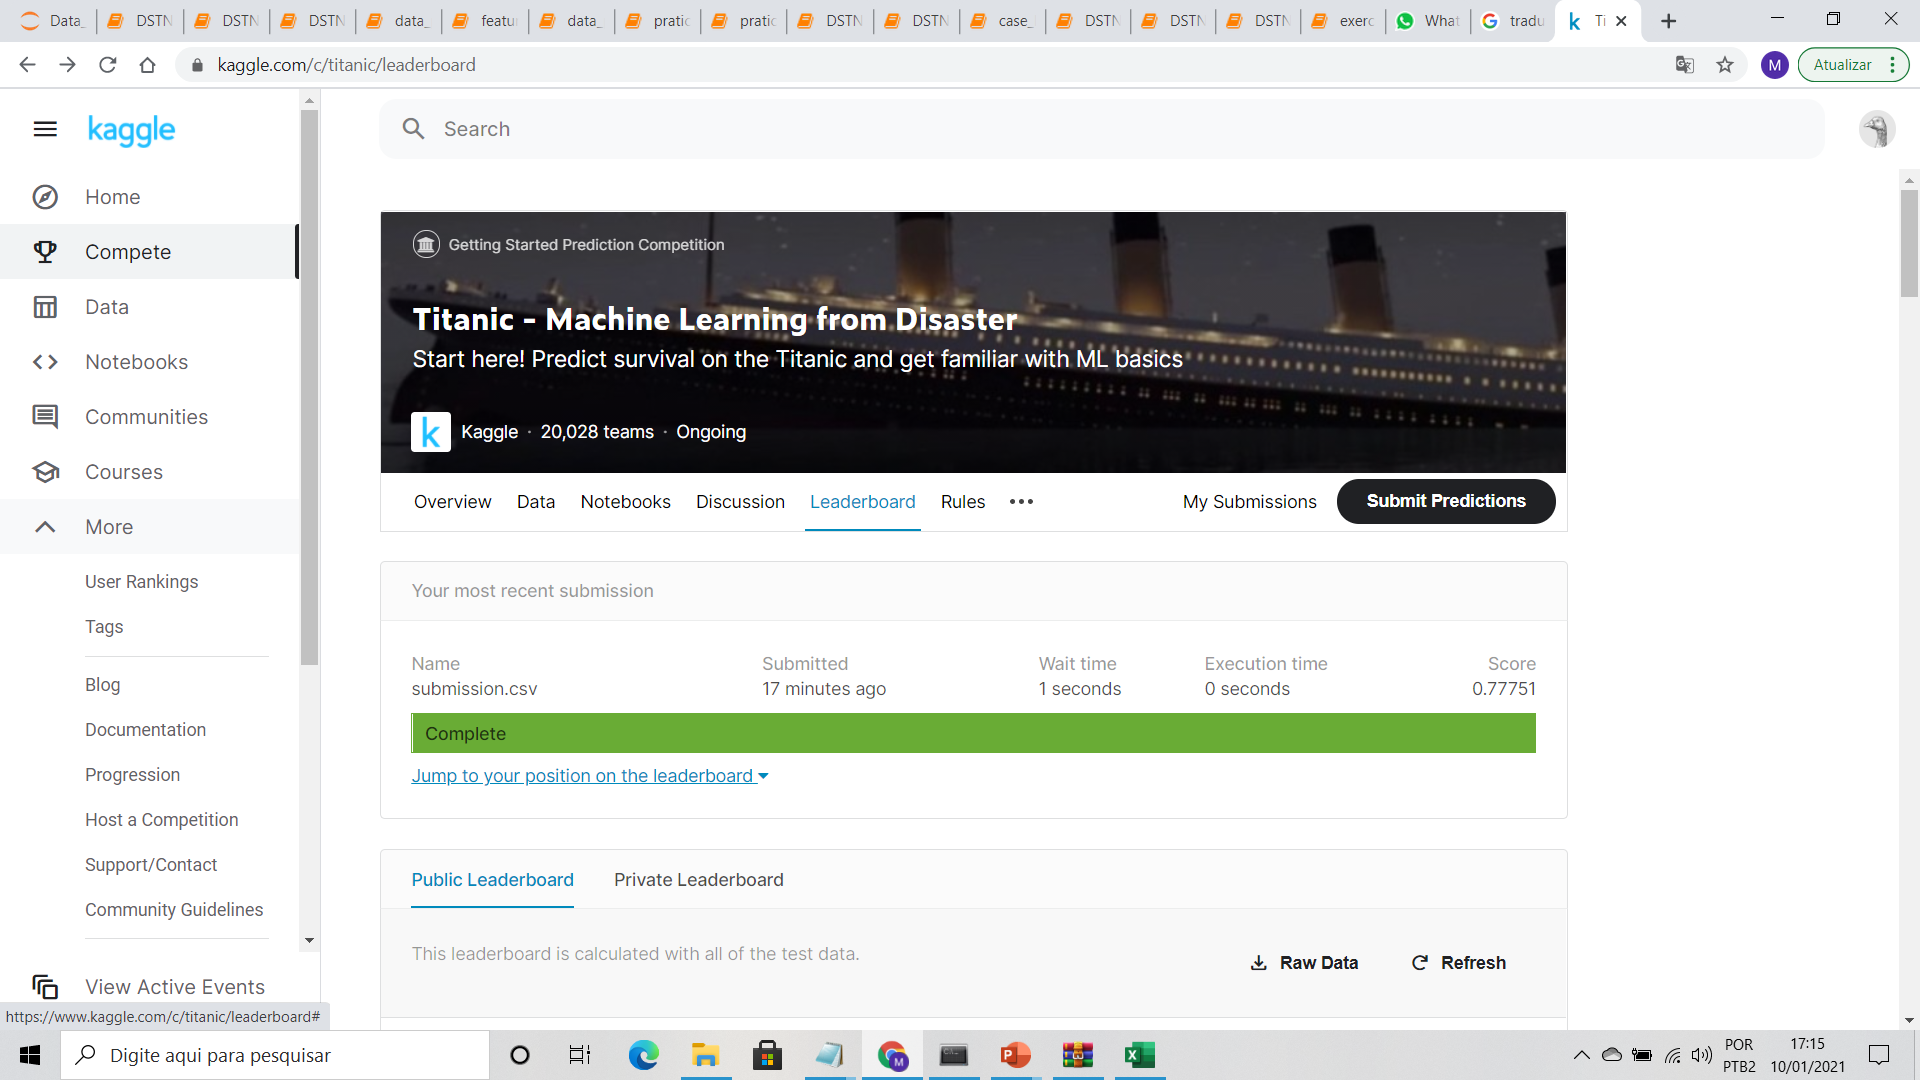